# **Tutorial 6: Ocean Heat Content**

**Week 1, Day 2: Ocean and Atmospheric Reanalysis**

__Content creators:__ Aurora Basinski

**Content reviewers:** Katrina Dobson, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Chi Zhang, Ohad Zivan

**Content editors:** Brodie, Pearson, Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google deepmind


![CMIP.png](https://github.com/ClimateMatchAcademy/course-content/blob/main/tutorials/Art/CMIP.png?raw=true)|
-


# **Tutorial Objectives**
In this tutorial, you will explore the ocean's vast heat capacity, which has a significant impact on the climate system. 

The ocean has a heat capacity that is approximately 1000 times greater than the entire atmosphere, due to the relatively large mass and specific heat capacity of water. This means that the ocean has a significant impact on Earth's thermal equilibrium state. *Ocean heat uptake* and *ocean carbon uptake* mitigates the effect of anthropogenic climate change by absorbing roughly 90% of the excess heat and 25% of human-emitted CO2. As you will see in this tutorial, ocean heat uptake largely occurs in the upper ocean as it is the region in contact with the atmosphere.

The ocean's high heat capacity also facilitates meridional ocean heat transport from the equator to the poles, which acts in addition to the meridional *atmospheric* heat transport.

Through this tutorial, you will explore the spatial distribution of heat in the ocean and how the ocean's  heat content is changing over time. To do this, you will utilize the [Estimating the Circulation and Climate of the Ocean (ECCO)](https://www.ecco-group.org/) dataset.

In [1]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

# **Setup**

In [2]:
# !pip install seaborn
# !pip install cmocean
# !pip install cartopy
# !pip install geoviews

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean
import os
import pooch
from scipy import integrate

# **Section 1: Vertical Distribution of Heat Within the Ocean**

First, let's load ECCO ocean temperature (`THETA`). This datasets contains the annual mean temperature over the period of 1992 to 2016.

In [4]:
# import preprocessed ECCO data. This data is full depth temperature data over 1992 to 2016 (annual mean)
# this file takes about 5 minutes to load
url_theta = "https://osf.io/c8wqt/download"
theta_annual= xr.open_dataset(pooch.retrieve(url_theta, known_hash=None))
theta_annual=theta_annual.THETA
theta_annual=theta_annual.where(theta_annual != 0) #make land points equal to NaN
theta_annual

<xarray.DataArray 'THETA' (year: 25, Z: 50, latitude: 360, longitude: 720)>
array([[[[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [271.24949362, 271.24949362, 271.24949362, ..., 271.24949362,
          271.24949362, 271.24949362],
         [271.2454257 , 271.2454257 , 271.2454257 , ..., 271.2454257 ,
          271.2454257 , 271.2454257 ],
         [271.24057818, 271.24057818, 271.24057818, ..., 271.24057818,
          271.24057818, 271.24057818]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
...
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]]]])
Coordinates:
    i          (longitude) int64 0 1 2 3 4 5 6 7 ... 713 714 715 716 717 718 719
    k          (Z) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    j          (latitude) int64 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * Z          (Z) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
    dZ         (Z) float64 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    Zu         (Z) float64 -10.0 -20.0 -30.0 ... -5.678e+03 -6.134e+03
    dA         (latitude, longitude) float64 1.349e+07 1.349e+07 ... 1.349e+07
    dX         (latitude, longitude) float64 121.3 121.3 121.3 ... 121.3 121.3
  * year       (year) int64 1992 1993 1994 1995 1996 ... 2013 2014 2015 2016

In [5]:
# take the mean over the period 1992 to 1994
subset_theta=theta_annual.sel(year=slice('1992', '1994')).mean('year')
subset_theta

<xarray.DataArray 'THETA' (Z: 50, latitude: 360, longitude: 720)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [271.23787993, 271.23787993, 271.23787993, ..., 271.23787993,
         271.23787993, 271.23787993],
        [271.23624212, 271.23624212, 271.23624212, ..., 271.23624212,
         271.23624212, 271.23624212],
        [271.23646802, 271.23646802, 271.23646802, ..., 271.23646802,
         271.23646802, 271.23646802]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
...
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
    i          (longitude) int64 0 1 2 3 4 5 6 7 ... 713 714 715 716 717 718 719
    k          (Z) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    j          (latitude) int64 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * Z          (Z) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
    dZ         (Z) float64 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    Zu         (Z) float64 -10.0 -20.0 -30.0 ... -5.678e+03 -6.134e+03
    dA         (latitude, longitude) float64 1.349e+07 1.349e+07 ... 1.349e+07
    dX         (latitude, longitude) float64 121.3 121.3 121.3 ... 121.3 121.3

Text(0.5, 1.0, 'Global zonal mean of temperature (C)')

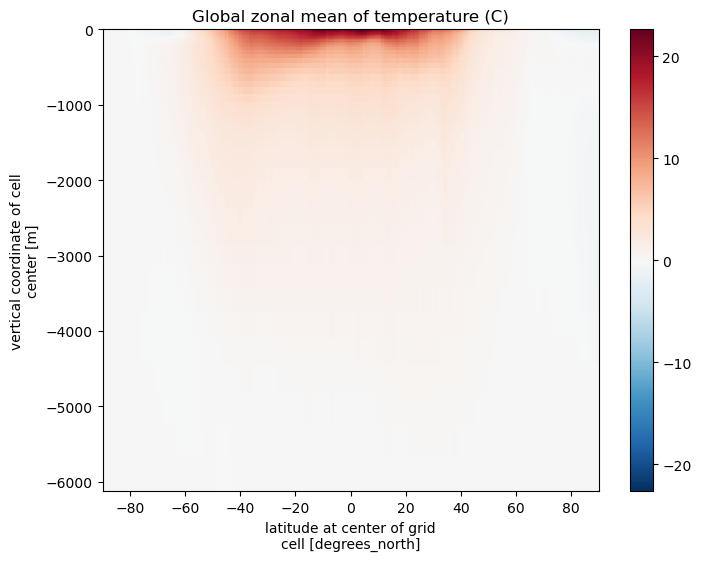

In [6]:
# plot a zonal mean slice of this data. we take a mean just in longitudes by dividing the dA coordinate by the
fig,ax = plt.subplots(figsize=(8,6))
(((subset_theta-273.15)*subset_theta.dX).sum('longitude')/(subset_theta.dX.sum('longitude'))).plot(ax=ax)
ax.set_title('Global zonal mean of temperature (C)')

Temperatures are warmest near the ocean's surface and close to the Equator, which suggests that heat is not distributed evenly within the ocean. **In this tutorial you will explore the spatial distribution of heat storage in the ocean (i.e., ocean heat content), and how this distribution is changing over time**. 

Heat content is typically measured in Joules, which is equivalent to the units kg$*$m$^2$/s$^2$. To determine the heat content within a specific depth range of the global ocean, i.e., between depth $z_1$ and the surface (height of 0), you can calculate a *volume integral* over the dimensions $x,y,$ and $z$. This integral can be written as:
$$\iiint_{-z_1}^0 c_p \cdot \rho_0 \cdot \theta(x,y,z) dz dA$$

Here, $dA$ represents the area integral over the $x$ and $y$ (lat, lon) coordinates. $\rho_0$ is the reference density in units of kg/m$^3$ and $c_p$ is specific heat capacity in units of J/(kg$*$K)

In [7]:
theta_area_int=(subset_theta*subset_theta.dA).sum('latitude').sum('longitude') #we take an area integral first at each depth level

Text(0.5, 1.0, 'Global Ocean Heat Content above each depth')

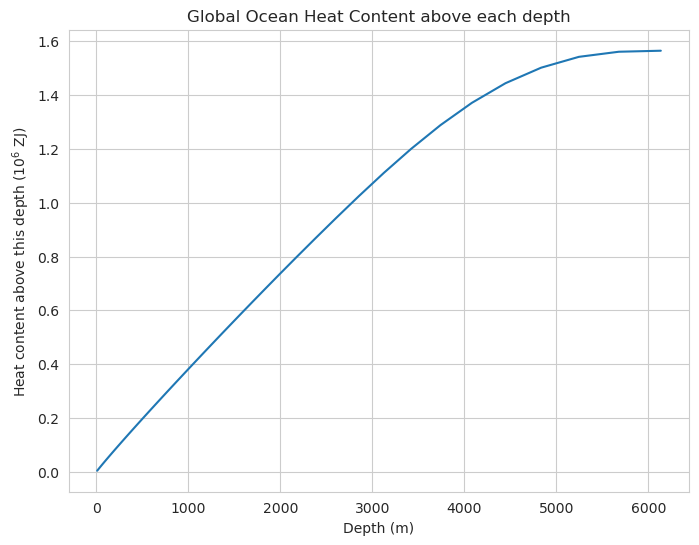

In [8]:
rho = 1026 #kg/m^3
c_p = 3990 #J/(kg K)

sns.set_style(style="whitegrid") 
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(-subset_theta.Zu,(rho*c_p*theta_area_int*subset_theta.dZ).cumsum()/10**27)
ax.set_xlabel('Depth (m)')
ax.set_ylabel('Heat content above this depth ($10^6$ ZJ)')
ax.set_title('Global Ocean Heat Content above each depth')

You can see that much of the ocean's heat is concentrated in the upper ocean (where the line is steep), with less heat stored in the deepest ocean regions (where the line plateaus). At first glance, this seems consistent with the zonal mean plot you plotted earlier in the tutorial, where the upper ocean tends to be warmer than deeper waters. However, in the integral equation above, $\theta$ is not the only depth-dependent term. The global ocean area ($A$) also varies with depth, with the area of the global ocean decreasing with depth until only a few deep trenches contain water at the greatest ocean depths.

Let's explore whether the ocean heat content plot we just created is driven by temperature variations or global ocean area variations with depth. One way to do this is to calculate and plot an integral of the global ocean area between each depth and the surface (i.e., the volume of the ocean above a each depth): $Volume(z) = \iiint_{-z_1}^0 dz dA$.

If the volume as a function of depth looks similar to the heat content plot above, it would suggest that the  smaller heat content of the deeper ocean (i.e., the plateau at large depths) is caused by the relatively small volume of water contained at these depths, rather than the vertical variations in temperature.


Text(0.5, 1.0, 'Global ocean volume above each depth')

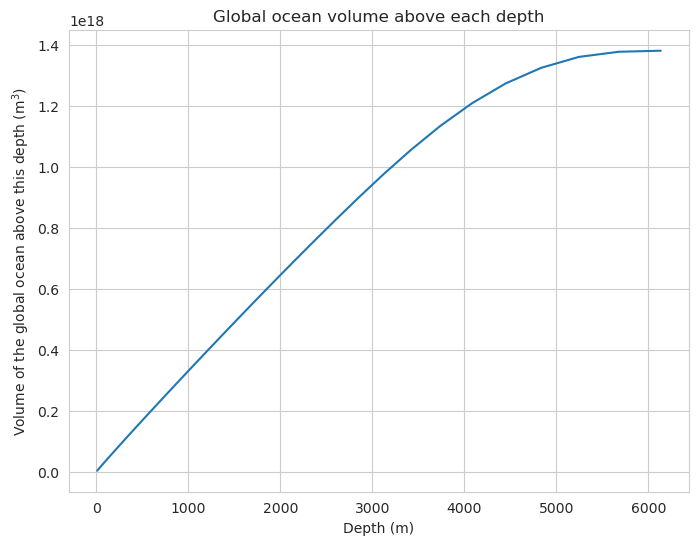

In [9]:
area_of_ocean=(subset_theta*subset_theta.dA/subset_theta).sum('latitude').sum('longitude') #we take an area integral first at each depth level

sns.set_style(style="whitegrid")
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(-subset_theta.Zu,(area_of_ocean*subset_theta.dZ).cumsum())
ax.set_xlabel('Depth (m)')
ax.set_ylabel('Volume of the global ocean above this depth (m$^3$)')
ax.set_title('Global ocean volume above each depth')

### **Question 1** 

1. Based on the last two plots, are depth-variations in ocean heat content primarily due to vertical changes in the temperature or area of the ocean?


In [10]:
# to_remove explanation

"""
1. The volume as a function of depth has a shape that is almost identical to the ocean heat content plot, which indicates that the ocean heat content above each depth is primarily shaped by depth-variations in the global ocean's area.
""";

# **Section 2: Changes in Ocean Heat Content**

In this section you will examine how the total (i.e., full-depth) heat content of the ocean has changed over time. You will also explore heat content changes within two specific upper-ocean layers: one above 700 m depth and another above 2000 m depth$^*$. By analyzing these near surface layers, you will identify whether changes in the ocean's heat content are evenly distributed through the water column.

$^*$*Note: technically the grid of the data means you will be looking above 677 m and 1997 m respectively*

In [11]:
#this cell may take a while to run!
rho = 1026 #kg/m^3
c_p = 3990 #J/(kg K)
global_heat,years_to_plot,global_heat_upper2000,global_heat_upper700=[],[],[],[]
for year in theta_annual.year: 
    years_to_plot.append(int(year))
    subset_theta_year=theta_annual.sel(year=int(year))
    global_heat.append(float(rho*c_p*(subset_theta_year*subset_theta_year.dZ*subset_theta_year.dA).sum('Z').sum('latitude').sum('longitude')))
    global_heat_upper2000.append(float(rho*c_p*((subset_theta_year.where(subset_theta_year.Zu>-2000)*subset_theta_year.dZ*subset_theta_year.dA).sum('Z').sum('latitude').sum('longitude'))))
    global_heat_upper700.append(float(rho*c_p*((subset_theta_year.where(subset_theta_year.Zu>-700)*subset_theta_year.dZ*subset_theta_year.dA).sum('Z').sum('latitude').sum('longitude'))))

# we now have lists, and list don't support math operations (-)
# we also divide the values by 10**21 to make them easier to read. 

heat_anom_fulldepth=[ (heat - global_heat[0])/10**21 for heat in global_heat] # remove year 1992
heat_anom_upper2000=[ (heat - global_heat_upper2000[0] )/10**21for heat in global_heat_upper2000] # remove year 1992
heat_anom_upper700=[( heat - global_heat_upper700[0])/10**21 for heat in global_heat_upper700] # remove year 1992
heat_anom_upper2000_700=[a - b for a, b in zip(heat_anom_upper2000, heat_anom_upper700)] # difference series between 2000 to 700
heat_anom_upperfulldepth_2000= [a - b for a, b in zip(heat_anom_fulldepth, heat_anom_upper2000)]# difference series between fulldepth to 2000

Text(0.5, 1.0, 'Change in heat over time')

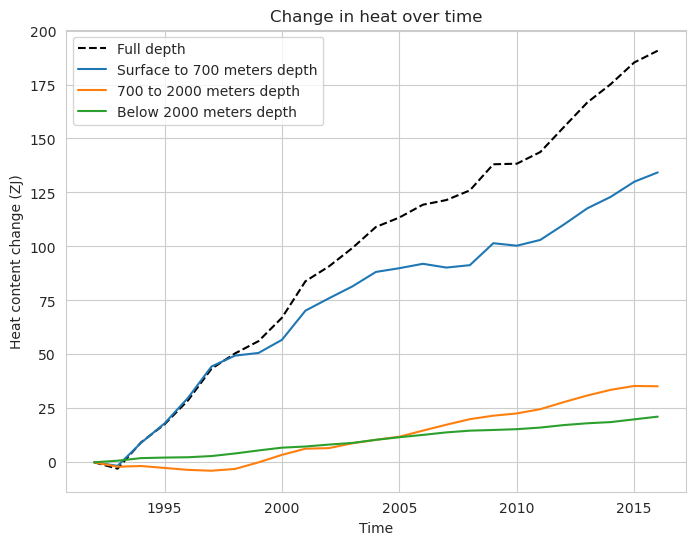

In [12]:
fig,ax = plt.subplots(figsize=(8,6))
sns.set_style(style="whitegrid")
ax.plot(years_to_plot,heat_anom_fulldepth, 'k--')
ax.plot(years_to_plot,heat_anom_upper700)
ax.plot(years_to_plot,heat_anom_upper2000_700)
ax.plot(years_to_plot,heat_anom_upperfulldepth_2000)
ax.set_xlabel('Time')
ax.set_ylabel('Heat content change (ZJ)')
ax.legend(['Full depth','Surface to 700 meters depth','700 to 2000 meters depth', 'Below 2000 meters depth'])
ax.set_title('Change in heat over time')

## **Questions 2** 

The volume of the ocean model in the reanalysis product does not change over time. Thus the *changes* in ocean heat content that you just calculated are caused by changes in the ocean's temperature. Most of the ocean's warming (heat gain) has been within the upper ocean (shallower than 700 m). The deeper ocean has also warmed, but not as substantially as near-surface waters.

1. Based on this graph, what percentage of the ocean's heat gain since 1992 is contained within the top 2000 meters?


In [13]:
# to_remove explanation

"""
1. The total heat gain is around 190 ZJ, while the upper layers have gained roughly 130 ZJ (above 700 m) and 35 ZJ (700-2000 m). This means the upper 2000 m contain (130+35)/190 = 87% of the ocean's heat gain, despite containing only ~50% of the ocean's water (see the volume plot you created in Section 1). 
""";

# **Section 3: Spatial Distribution of Ocean Heat Content**

You just saw that the ocean heat increase is concentrated near the ocean surface. **Now you will explore where that heat is stored as a function of latitude and longitude**. You can do this by creating a global map of ocean heat content in the upper 700 m of the ocean - which is essentially the same integral as above without the horizontal area integral: $\int_{-700m}^0 c_p\rho_0\theta(x,y,z) dz$

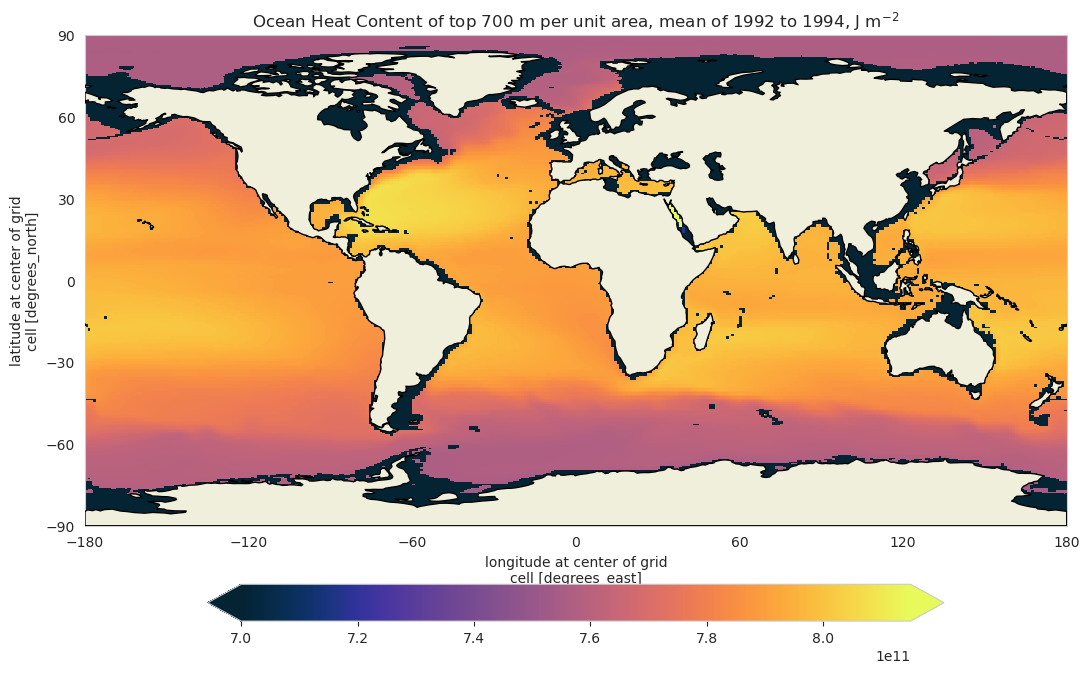

In [14]:
# first let's plot where heat is stored in the mean
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html

p=(((rho*c_p*subset_theta.where(-subset_theta.Zu<700)*subset_theta.dZ).sum('Z'))).plot(
    vmin=7e11,vmax=8.15E11,cmap=cmocean.cm.thermal,
    cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': ""},ax=ax
)
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax.set_title('Ocean Heat Content of top 700 m per unit area, mean of 1992 to 1994, J m$^{-2}$')
fig.tight_layout()

The lower latitude ocean contains more heat than the higher latitudes. This finding is consistent with your previous plot of warmer waters near the Equator during this tutorial. 

*Note: the color scale of this figure was chosen to emphasize latitudinal differences in ocean heat conent. As a result, some regions with shallow water depth display as black on the plot due to their relatively low column-integrated ocean heat content ($<7 \times 10^{11} J m^{-2}$). **These black regions do not have zero ocean heat content.***

Now let's explore the spatial pattern of (full-depth) ocean heat content *rate of change* between 1992 and 2016.

In [15]:
# we already defined an object that's the mean over years 1992 to 1994 (subset_theta)
# now define an object that's the mean over 2014 to 2016
subset_theta_future=theta_annual.sel(year=slice('2014', '2016')).mean('year')

length_of_time_period = 24*60*60*365*(2015-1993)

full_depth_heat_content_change = (rho*c_p*subset_theta_future*subset_theta_future.dZ).sum('Z')-(rho*c_p*subset_theta*subset_theta.dZ).sum('Z')
upper_700m_heat_content_change = (rho*c_p*subset_theta_future.where(-subset_theta.Zu<700)*subset_theta_future.dZ).sum('Z')-(rho*c_p*subset_theta.where(-subset_theta.Zu<700)*subset_theta.dZ).sum('Z')

<bound method Figure.tight_layout of <Figure size 1100x1200 with 4 Axes>>

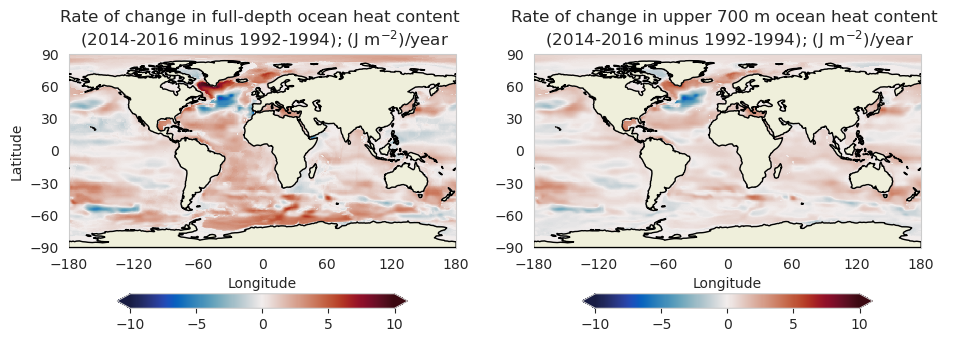

In [16]:
fig, ax = plt.subplots(1, 2, subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
(full_depth_heat_content_change/length_of_time_period).plot(ax=ax[0],vmin=-10,vmax=10,cmap=cmocean.cm.balance,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': ""})
(upper_700m_heat_content_change/length_of_time_period).plot(ax=ax[1],vmin=-10,vmax=10,cmap=cmocean.cm.balance,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': ""})
ax[0].coastlines(color='grey',lw=0.5)
ax[0].set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax[0].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax[0].add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax[0].set_title('Rate of change in full-depth ocean heat content \n (2014-2016 minus 1992-1994); (J m$^{-2}$)/year')
fig.tight_layout
ax[1].coastlines(color='grey',lw=0.5)
ax[1].set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax[0].set_ylabel('Latitude')
ax[1].set_ylabel('')
ax[0].set_xlabel('Longitude')
ax[1].set_xlabel('Longitude')
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax[1].add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax[1].set_title('Rate of change in upper 700 m ocean heat content \n (2014-2016 minus 1992-1994); (J m$^{-2}$)/year')
fig.tight_layout

With these plots, you demonstrated that ocean heat gain is not evenly distributed across space. When comparing the two plots, you once again see that the upper ocean contains a large fraction of the warming (recall that Equatorial regions contribute more to the global mean than high-latitude regions becasue of their relatively large area).

# **Summary**

In this tutorial, you have quantified the spatial patterns and temporal changes of the ocean's heat content. You showed that the upper layers of the ocean contain most of the ocean's heat content, due to their relatively large area (and hence volume) compared to the deepest ocean layers. These upper layers also experience a disproportionately large fraction of the ocean warming that has been observed in recent decades. You also found that heat content distribution varies by latitude and longitude, and is typically greater in the lower latitudes, and the ocean's heat gain over time is not uniformly distributed across different oceanic regions.

# **Resources**

Data for this tutorial can be accessed [here](https://www.ecco-group.org/).